<a href="https://colab.research.google.com/github/reiinakano/diff-painter/blob/master/notebooks/generate_stroke_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

## Optionally connect to Drive for saving

In [0]:
#from google.colab import drive
#drive.mount('/drive')

## Install MyPaint

In [0]:
# Install mypaint
!apt-get update
!apt-get install libjson-c-dev libgirepository1.0-dev libglib2.0-dev
!apt-get install autotools-dev intltool gettext libtool
!apt-get install swig python-setuptools gettext g++
!apt-get install -y libgtk-3-dev python-gi-dev
!apt-get install -y libpng-dev liblcms2-dev libjson-c-dev
!apt-get install -y gir1.2-gtk-3.0 python-gi-cairo
!apt-get install scons

!wget https://github.com/mypaint/libmypaint/releases/download/v1.3.0/libmypaint-1.3.0.tar.xz
!tar -xvf libmypaint-1.3.0.tar.xz
!mv libmypaint-1.3.0 libmypaint

!cd libmypaint && ./configure && make install

!wget https://github.com/mypaint/mypaint/releases/download/v1.2.1/mypaint-1.2.1.tar.xz
!tar -xvf mypaint-1.2.1.tar.xz
!mv mypaint-1.2.1 mypaint
!cd mypaint && scons && scons install

!ldconfig

!pip install ipdb tqdm pathlib cloudpickle future-fstrings matplotlib

## Fetch a package for using the MyPaint environment

In [3]:
!git clone https://github.com/reiinakano/SPIRAL-tensorflow.git
!cd SPIRAL-tensorflow && git checkout reiinakano-patch-2  #reiinakano-patches

Cloning into 'SPIRAL-tensorflow'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 154 (delta 3), reused 0 (delta 0), pack-reused 146
Receiving objects: 100% (154/154), 1.36 MiB | 2.91 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Branch 'reiinakano-patch-2' set up to track remote branch 'reiinakano-patch-2' from 'origin'.
Switched to a new branch 'reiinakano-patch-2'


# Imports

In [0]:
import sys
import os
from pathlib import Path

from PIL import Image
import numpy as np

sys.path.append('mypaint')
sys.path.append('SPIRAL-tensorflow')
#import envs.mnist

from tqdm import tqdm
import tensorflow as tf
from PIL import Image, ImageDraw
from collections import defaultdict

from lib import surface, tiledsurface, brush
from envs.mypaint_utils import *
import matplotlib.pyplot as plt

# Set up paint environment

In [0]:
class args:
  jump=True
  curve=True
  screen_size=64
  location_size=32
  color_channel=3
  brush_path='SPIRAL-tensorflow/assets/brushes/dry_brush.myb'
  data_dir=Path('data')

In [0]:
class PaintMode:
  STROKES_ONLY = 0
  JUMP_STROKES = 1
  CONNECTED_STROKES = 2

class ColorEnv():
    head = 0.25
    tail = 0.75
    
    # all 0 to 1
    actions_to_idx = {
        'pressure': 0,
        'size': 1,
        'control_x': 2,
        'control_y': 3,
        'end_x': 4,
        'end_y': 5,
        'color_r': 6,
        'color_g': 7,
        'color_b': 8,
        'start_x': 9,
        'start_y': 10,
        'entry_pressure': 11,
    }

    def __init__(self, args, paint_mode=PaintMode.JUMP_STROKES):
        self.args = args
        self.paint_mode = paint_mode

        # screen
        self.screen_size = args.screen_size
        self.height, self.width = self.screen_size, self.screen_size
        self.observation_shape = [
                self.height, self.width, args.color_channel]

        # location
        self.location_size = args.location_size
        self.location_shape = [self.location_size, self.location_size]
        
        self.prev_x, self.prev_y, self.prev_pressure = None, None, None
    
    @staticmethod
    def pretty_print_action(ac):
        for k, v in ColorEnv.actions_to_idx.items():
            print(k, ac[v])
    
    def random_action(self):
        return np.random.uniform(size=[len(self.actions_to_idx)])
      
    def reset(self):
        self.intermediate_images = []
        self.prev_x, self.prev_y, self.prev_pressure = None, None, None

        self.s = tiledsurface.Surface()
        self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
        self.s.begin_atomic()

        with open(self.args.brush_path) as fp:
            self.bi = brush.BrushInfo(fp.read())
        self.b = brush.Brush(self.bi)

    def draw(self, ac, s=None, dtime=1):
        # Just added this
        if self.paint_mode == PaintMode.STROKES_ONLY:
          self.s.clear()
          self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
          self.s.end_atomic()
          self.s.begin_atomic()
        
        if s is None:
            s = self.s

        s_x, s_y = ac[self.actions_to_idx['start_x']]*64, ac[self.actions_to_idx['start_y']]*64  
        e_x, e_y = ac[self.actions_to_idx['end_x']]*64, ac[self.actions_to_idx['end_y']]*64
        c_x, c_y = ac[self.actions_to_idx['control_x']]*64, ac[self.actions_to_idx['control_y']]*64
        color = (
            ac[self.actions_to_idx['color_r']],
            ac[self.actions_to_idx['color_g']],
            ac[self.actions_to_idx['color_b']],
        )
        pressure = ac[self.actions_to_idx['pressure']]*0.8
        entry_pressure = ac[self.actions_to_idx['entry_pressure']]*0.8
        size = ac[self.actions_to_idx['size']] * 2.
        
        if self.paint_mode == PaintMode.CONNECTED_STROKES:
            if self.prev_x is not None:
                s_x, s_y, entry_pressure = self.prev_x, self.prev_y, self.prev_pressure
            self.prev_x, self.prev_y, self.prev_pressure = e_x, e_y, pressure

        self.b.brushinfo.set_color_rgb(color)
        
        self.b.brushinfo.set_base_value('radius_logarithmic', size)

        # Move brush to starting point without leaving it on the canvas.
        self._stroke_to(s_x, s_y, 0)

        self._draw(s_x, s_y, e_x, e_y, c_x, c_y, entry_pressure, pressure, size, color, dtime)

    def _draw(self, s_x, s_y, e_x, e_y, c_x, c_y,
              entry_pressure, pressure, size, color, dtime):

        # if straight line or jump
        if pressure == 0:
            self.b.stroke_to(
                    self.s.backend, e_x, e_y, pressure, 0, 0, dtime)
        else:
            self.curve(c_x, c_y, s_x, s_y, e_x, e_y, entry_pressure, pressure)
            
        # Relieve brush pressure for next jump
        self._stroke_to(e_x, e_y, 0)

        self.s.end_atomic()
        self.s.begin_atomic()

    # sx, sy = starting point
    # ex, ey = end point
    # kx, ky = curve point from last line
    # lx, ly = last point from InteractionMode update
    def curve(self, cx, cy, sx, sy, ex, ey, entry_pressure, pressure):
        #entry_p, midpoint_p, junk, prange2, head, tail
        entry_p, midpoint_p, prange1, prange2, h, t = \
                self._line_settings(entry_pressure, pressure)

        points_in_curve = 100
        mx, my = midpoint(sx, sy, ex, ey)
        length, nx, ny = length_and_normal(mx, my, cx, cy)
        cx, cy = multiply_add(mx, my, nx, ny, length*2)
        x1, y1 = difference(sx, sy, cx, cy)
        x2, y2 = difference(cx, cy, ex, ey)
        head = points_in_curve * h
        head_range = int(head)+1
        tail = points_in_curve * t
        tail_range = int(tail)+1
        tail_length = points_in_curve - tail

        # Beginning
        px, py = point_on_curve_1(1, cx, cy, sx, sy, x1, y1, x2, y2)
        length, nx, ny = length_and_normal(sx, sy, px, py)
        bx, by = multiply_add(sx, sy, nx, ny, 0.25)
        self._stroke_to(bx, by, entry_p)
        pressure = abs(1/head * prange1 + entry_p)
        self._stroke_to(px, py, pressure)

        for i in xrange(2, head_range):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            pressure = abs(i/head * prange1 + entry_p)
            self._stroke_to(px, py, pressure)

        # Middle
        for i in xrange(head_range, tail_range):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            self._stroke_to(px, py, midpoint_p)

        # End
        for i in xrange(tail_range, points_in_curve+1):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            pressure = abs((i-tail)/tail_length * prange2 + midpoint_p)
            self._stroke_to(px, py, pressure)

        return pressure

    def _stroke_to(self, x, y, pressure, duration=0.1):
        self.b.stroke_to(
                self.s.backend,
                x, y,
                pressure,
                0.0, 0.0,
                duration)
        self.s.end_atomic()
        self.s.begin_atomic()
        self.intermediate_images.append(self.image)

    def save_image(self, path="test.png"):
        Image.fromarray(self.image.astype(np.uint8).squeeze()).save(path)
        #self.s.save_as_png(path, alpha=False)

    @property
    def image(self):
        rect = [0, 0, self.height, self.width]
        scanline_strips = \
                surface.scanline_strips_iter(self.s, rect)
        return next(scanline_strips)

    def _line_settings(self, entry_pressure, pressure):
        p1 = entry_pressure
        p2 = (entry_pressure + pressure) / 2
        p3 = pressure
        if self.head == 0.0001:
            p1 = p2
        prange1 = p2 - p1
        prange2 = p3 - p2
        return p1, p2, prange1, prange2, self.head, self.tail


## Sanity check paint environment

[Step 0] ac: [0.26404815 0.96822001 0.15672115 0.82396459 0.55500448 0.25566826
 0.02312342 0.9990442  0.50381175 0.529559   0.16601173 0.99508717]
('end_y', 0.255668260693107)
('end_x', 0.5550044837676973)
('color_g', 0.9990441960515342)
('color_b', 0.5038117495288398)
('pressure', 0.2640481532670036)
('entry_pressure', 0.9950871716775643)
('color_r', 0.023123417389094736)
('size', 0.9682200100059787)
('control_y', 0.8239645860429625)
('control_x', 0.1567211532692091)
('start_x', 0.5295589957275088)
('start_y', 0.1660117310655207)


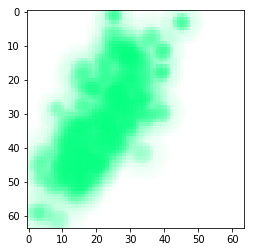

[Step 1] ac: [0.1023948  0.00936818 0.66990414 0.39761406 0.30366414 0.59681869
 0.57223802 0.85706269 0.71255906 0.72911998 0.94880299 0.58340493]
('end_y', 0.5968186902178001)
('end_x', 0.30366414048940904)
('color_g', 0.8570626923349071)
('color_b', 0.7125590572008813)
('pressure', 0.10239480379446841)
('entry_pressure', 0.5834049287336872)
('color_r', 0.5722380174290482)
('size', 0.009368175149796154)
('control_y', 0.39761405517650417)
('control_x', 0.6699041443957969)
('start_x', 0.7291199844344761)
('start_y', 0.9488029948662642)


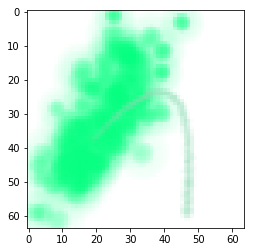

[Step 2] ac: [0.96587299 0.76489805 0.71957098 0.39055768 0.95974236 0.55350308
 0.96092335 0.34436994 0.51391299 0.74046183 0.85389628 0.38754596]
('end_y', 0.5535030804642671)
('end_x', 0.9597423622339342)
('color_g', 0.34436993670879856)
('color_b', 0.5139129859386249)
('pressure', 0.9658729929085194)
('entry_pressure', 0.38754596201020397)
('color_r', 0.9609233549809425)
('size', 0.7648980535788686)
('control_y', 0.3905576761852112)
('control_x', 0.7195709799868061)
('start_x', 0.7404618281675478)
('start_y', 0.8538962786161334)


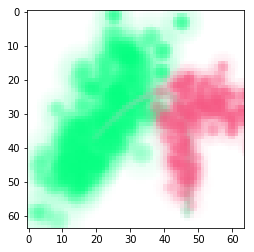

[Step 3] ac: [0.3557302  0.00308079 0.12483841 0.82961693 0.25336996 0.64261501
 0.9151078  0.3691103  0.97120005 0.38226892 0.27619563 0.64140084]
('end_y', 0.6426150071525691)
('end_x', 0.2533699593771812)
('color_g', 0.36911030044049375)
('color_b', 0.9712000480463424)
('pressure', 0.35573020007108636)
('entry_pressure', 0.6414008443789228)
('color_r', 0.9151077964708547)
('size', 0.003080790273704337)
('control_y', 0.8296169346434754)
('control_x', 0.12483841406868024)
('start_x', 0.38226892287354897)
('start_y', 0.27619562740168646)


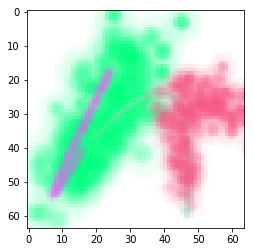

[Step 4] ac: [0.82820981 0.51598894 0.37106164 0.72665257 0.61908719 0.57036894
 0.26007435 0.80208871 0.35733639 0.5359044  0.93886554 0.39163037]
('end_y', 0.5703689352742707)
('end_x', 0.6190871866356761)
('color_g', 0.8020887098317845)
('color_b', 0.3573363885998133)
('pressure', 0.8282098107086984)
('entry_pressure', 0.3916303740012448)
('color_r', 0.2600743518227354)
('size', 0.5159889409836421)
('control_y', 0.7266525695130116)
('control_x', 0.37106163846648565)
('start_x', 0.5359043961075507)
('start_y', 0.9388655449682708)


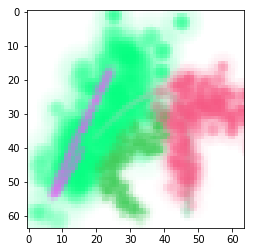

In [4]:
env=ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)

try:
  os.makedirs('data/generated')
except OSError:
  pass

for ep_idx in range(1):
    env.reset()

    for i in range(5):
        action = env.random_action()
        #action[env.actions_to_idx['color_r']] = 0.50
        #action[env.actions_to_idx['color_g']] = 0.2
        #action[env.actions_to_idx['color_b']] = 0.3
        print("[Step {}] ac: {}".format(i, action))
        ColorEnv.pretty_print_action(action)
        env.draw(action)
        plt.imshow(env.image)
        plt.show()
        env.save_image("data/generated/mnist{}_{}.png".format(ep_idx, i))

[Step 0] ac: [0.93273729 0.88879811 0.44361509 0.30820941 0.64586243 0.26765199
 0.07082042 0.24761258 0.54161853 0.85851301 0.9840184  0.53020547]
('end_y', 0.2676519890379069)
('end_x', 0.6458624305453227)
('color_g', 0.24761258061517588)
('color_b', 0.5416185291241625)
('pressure', 0.9327372928077287)
('entry_pressure', 0.5302054734953655)
('color_r', 0.0708204231802464)
('size', 0.8887981063900303)
('control_y', 0.30820941013104575)
('control_x', 0.4436150901438063)
('start_x', 0.8585130096303563)
('start_y', 0.9840183957669343)


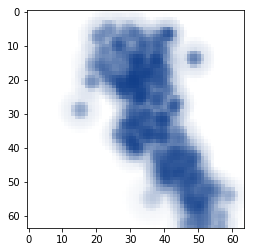

[Step 1] ac: [0.36515062 0.30124581 0.47204964 0.65072222 0.65151745 0.58561212
 0.94529997 0.07012821 0.39330104 0.09341873 0.13907208 0.57115726]
('end_y', 0.5856121174382521)
('end_x', 0.6515174493639371)
('color_g', 0.07012821322132035)
('color_b', 0.39330104113802933)
('pressure', 0.3651506189444672)
('entry_pressure', 0.5711572595887029)
('color_r', 0.9452999666942634)
('size', 0.30124580694182057)
('control_y', 0.6507222235396223)
('control_x', 0.4720496399596482)
('start_x', 0.09341872594776623)
('start_y', 0.1390720766097302)


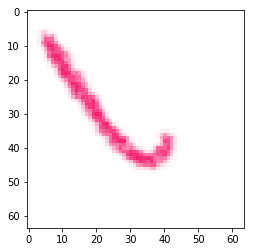

[Step 2] ac: [0.09476984 0.23737978 0.45335428 0.42428263 0.4455534  0.65612943
 0.19244729 0.01741144 0.76810654 0.01604109 0.57286472 0.10633994]
('end_y', 0.6561294325314068)
('end_x', 0.44555340086482953)
('color_g', 0.017411440663484545)
('color_b', 0.768106540693279)
('pressure', 0.09476983659940319)
('entry_pressure', 0.10633994436518801)
('color_r', 0.19244729181189735)
('size', 0.23737978067958754)
('control_y', 0.42428262690577456)
('control_x', 0.45335428471462236)
('start_x', 0.016041085908013786)
('start_y', 0.5728647197065228)


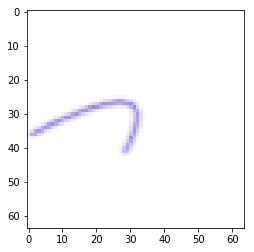

[Step 3] ac: [0.56323853 0.60769168 0.24782252 0.95826642 0.35986308 0.21879381
 0.3866676  0.53685841 0.00205911 0.71798041 0.34658607 0.87065781]
('end_y', 0.21879380981931118)
('end_x', 0.3598630810590875)
('color_g', 0.5368584072771373)
('color_b', 0.002059114656629779)
('pressure', 0.5632385291365636)
('entry_pressure', 0.8706578070325454)
('color_r', 0.3866676046596915)
('size', 0.6076916789220893)
('control_y', 0.9582664209477781)
('control_x', 0.24782251608811356)
('start_x', 0.7179804087376247)
('start_y', 0.34658606848380813)


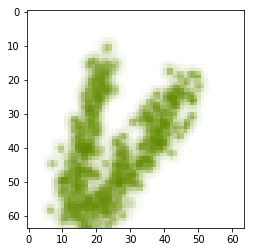

[Step 4] ac: [0.46326046 0.68938223 0.81022043 0.31715687 0.56169805 0.53509667
 0.57993134 0.47325214 0.32227619 0.00099051 0.53090457 0.7133904 ]
('end_y', 0.5350966703563642)
('end_x', 0.5616980510440263)
('color_g', 0.4732521440564966)
('color_b', 0.3222761863805066)
('pressure', 0.46326046078452465)
('entry_pressure', 0.7133903961725964)
('color_r', 0.5799313384080698)
('size', 0.6893822342459711)
('control_y', 0.3171568685266385)
('control_x', 0.8102204263584482)
('start_x', 0.0009905088440437249)
('start_y', 0.5309045650884464)


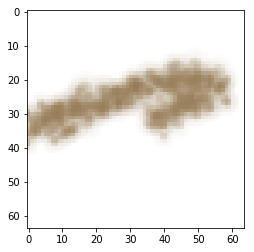

In [5]:
env=ColorEnv(args, paint_mode=PaintMode.STROKES_ONLY)

try:
  os.makedirs('data/generated')
except OSError:
  pass

for ep_idx in range(1):
    env.reset()

    for i in range(5):
        action = env.random_action()
        #action[env.actions_to_idx['color_r']] = 0.50
        #action[env.actions_to_idx['color_g']] = 0.2
        #action[env.actions_to_idx['color_b']] = 0.3
        print("[Step {}] ac: {}".format(i, action))
        ColorEnv.pretty_print_action(action)
        env.draw(action)
        plt.imshow(env.image)
        plt.show()
        env.save_image("data/generated/mnist{}_{}.png".format(ep_idx, i))

[Step 0] ac: [0.32542663 0.37338011 0.36733832 0.48550354 0.23065611 0.23097348
 0.45006508 0.21099824 0.16291906 0.24169058 0.72456516 0.        ]
('end_y', 0.230973482733566)
('end_x', 0.23065611341710412)
('color_g', 0.21099823920283978)
('color_b', 0.16291906446897064)
('pressure', 0.325426627643262)
('entry_pressure', 0.0)
('color_r', 0.45006507593491396)
('size', 0.3733801136177013)
('control_y', 0.48550354234559234)
('control_x', 0.36733832463080496)
('start_x', 0.24169057786216064)
('start_y', 0.7245651603918453)


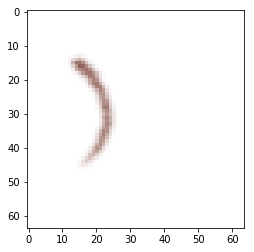

[Step 1] ac: [0.03044385 0.43777396 0.35321483 0.34914334 0.26010034 0.87082733
 0.23282752 0.05244238 0.01913243 0.34816328 0.41009838 0.        ]
('end_y', 0.8708273330860063)
('end_x', 0.26010034026881035)
('color_g', 0.05244237768434523)
('color_b', 0.0191324263207161)
('pressure', 0.03044384524715349)
('entry_pressure', 0.0)
('color_r', 0.23282752039353372)
('size', 0.43777396232244514)
('control_y', 0.3491433391822223)
('control_x', 0.3532148303589294)
('start_x', 0.3481632764775672)
('start_y', 0.4100983775675553)


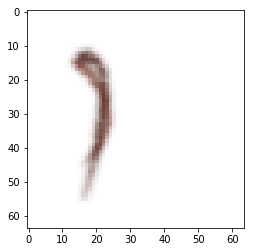

[Step 2] ac: [0.00355761 0.99963391 0.76194057 0.83948911 0.66236439 0.80897455
 0.32711967 0.9174523  0.16179189 0.1977505  0.13337123 0.        ]
('end_y', 0.8089745475184195)
('end_x', 0.6623643930583905)
('color_g', 0.9174522979697065)
('color_b', 0.16179188837154068)
('pressure', 0.0035576058829480672)
('entry_pressure', 0.0)
('color_r', 0.3271196731498318)
('size', 0.999633912948483)
('control_y', 0.8394891101499349)
('control_x', 0.7619405736245075)
('start_x', 0.1977504994387269)
('start_y', 0.13337123415109253)


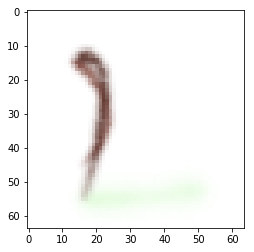

[Step 3] ac: [0.20891175 0.92287791 0.72349815 0.296454   0.92919243 0.24524658
 0.22189355 0.04993547 0.33627227 0.45439776 0.69748406 0.        ]
('end_y', 0.24524658330318427)
('end_x', 0.9291924255303122)
('color_g', 0.04993547376523011)
('color_b', 0.3362722725734334)
('pressure', 0.20891174905536225)
('entry_pressure', 0.0)
('color_r', 0.2218935537794937)
('size', 0.922877905665151)
('control_y', 0.2964539985294652)
('control_x', 0.7234981475387975)
('start_x', 0.4543977553412989)
('start_y', 0.6974840583596295)


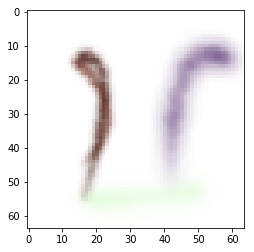

[Step 4] ac: [0.83328842 0.98344846 0.33902685 0.89123158 0.52925477 0.91303524
 0.24966657 0.2142516  0.83175996 0.96174141 0.73542546 0.        ]
('end_y', 0.9130352411236383)
('end_x', 0.5292547683514356)
('color_g', 0.2142515993495543)
('color_b', 0.8317599640955169)
('pressure', 0.8332884207039201)
('entry_pressure', 0.0)
('color_r', 0.24966657442185525)
('size', 0.9834484610593238)
('control_y', 0.891231583965259)
('control_x', 0.3390268529310515)
('start_x', 0.9617414052565931)
('start_y', 0.7354254600146377)


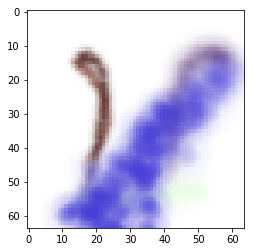

In [6]:
env=ColorEnv(args, paint_mode=PaintMode.CONNECTED_STROKES)

try:
  os.makedirs('data/generated')
except OSError:
  pass

for ep_idx in range(1):
    env.reset()

    for i in range(5):
        action = env.random_action()
        #action[env.actions_to_idx['color_r']] = 0.50
        #action[env.actions_to_idx['color_g']] = 0.2
        #action[env.actions_to_idx['color_b']] = 0.3
        action[env.actions_to_idx['entry_pressure']] = 0.
        print("[Step {}] ac: {}".format(i, action))
        ColorEnv.pretty_print_action(action)
        env.draw(action)
        plt.imshow(env.image)
        plt.show()
        env.save_image("data/generated/mnist{}_{}.png".format(ep_idx, i))

# Generate action to brushstroke image examples

This takes a long time. You might want to adjust the number of shards or change the Colab runtime to local or save directly to Google Drive to avoid losing progress.

Alternatively, just skip this step and download the strokes I generated.

In [0]:
env=ColorEnv(args, paint_mode=PaintMode.STROKES_ONLY)

try:
  os.makedirs('data')
except OSError:
  pass

NUM_SHARDS = 80
NUM_STROKES_PER_SHARD = 100000

SHARD_NUM_OFFSET = 0

for i in range(SHARD_NUM_OFFSET, SHARD_NUM_OFFSET+NUM_SHARDS):
  print('shard', i)
  actions = []
  strokes = []
  for idx in range(NUM_STROKES_PER_SHARD):
    env.reset()
    if idx % 2000 == 0: print(idx)
    
    action = env.random_action()
    actions.append(action)
    env.draw(action)
    strokes.append(env.image[:, :, :3])
  actions = np.array(actions, dtype=np.float)
  strokes = np.array(strokes, dtype=np.uint8)
  np.savez_compressed("data/episodes_{}.npz".format(i), actions=actions, strokes=strokes)


# Test out the generated files

In [0]:
loaded = np.load('data/episodes_0.npz')

In [9]:
print loaded['actions'].shape
print loaded['strokes'].shape


(100000, 12)
(100000, 64, 64, 3)


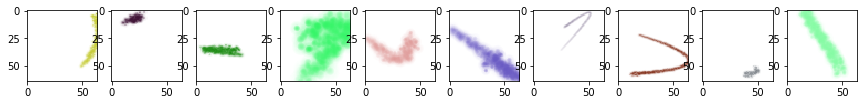

In [10]:
import matplotlib.pyplot as plt

w=args.screen_size
h=args.screen_size
fig=plt.figure(figsize=(30, 10))
cols = 10

smaller_arr = loaded['strokes'][:cols]

for col in range(cols):
    img = smaller_arr[col][:, :, :3]
    #print(img.shape)
    fig.add_subplot(1, 20, col+1)
    plt.grid(False)
    plt.imshow(img)
plt.show()

In [0]:
for ac in loaded['actions'][:cols]:
  print('___')
  ColorEnv.pretty_print_action(ac)

In [0]:
"""

env=ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)
#env2 = ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)

try:
  os.makedirs('data')
except OSError:
  pass

NUM_STROKES = 200000
NUM_SHARDS = 1
NUM_STROKES_PER_SHARD = NUM_STROKES/NUM_SHARDS

for i in range(NUM_SHARDS):
  env.reset()
  #env2.reset()
  actions = []
  strokes = []
  #full_images = []
  for idx in range(NUM_STROKES_PER_SHARD):
    if idx % 2000 == 0: print(idx)
    
    action = env.random_action()
    actions.append(action)
    env.draw(action)
    #env2.draw(action)
    strokes.append(env.image[:, :, :3])
    #full_images.append(env2.image[:, :, :3])
  actions = np.array(actions, dtype=np.float)
  strokes = np.array(strokes, dtype=np.uint8)
  #full_images = np.array(full_images, dtype=np.uint8)
  np.savez_compressed("data/full_strokes_{}.npz".format(i), actions=actions, strokes=strokes)
"""